In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from splinator.estimators import LinearSplineLogisticRegression

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score
from sklearn.isotonic import IsotonicRegression

In [25]:
from splinator.monotonic_spline import _get_design_matrix
from splinator.estimators import LinearSplineLogisticRegression

In [26]:
from sklearn.datasets import make_classification

In [27]:
X, y = make_classification(n_samples=50000, n_features=10, n_informative=2, n_redundant=8, flip_y=0.15)

# split train, test for calibration
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

X_train, X_dev, y_train, y_dev = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

In [28]:
clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)

clf_pred_dev = clf.predict_proba(X_dev)[:,1]
clf_pred_test = clf.predict_proba(X_test)[:,1]

In [29]:
roc_auc_score(y_score=clf_pred_dev, y_true=y_dev)

0.8958574486358871

In [36]:
lslr = LinearSplineLogisticRegression(
        n_knots=20, 
        monotonicity="none", 
        minimizer_options={'disp': True}, 
        method='SLSQP', 
        two_stage_fitting_initial_size=2000
    )
lslr.fit( clf_pred_dev.reshape( -1, 1 ), y_dev )
lslr_pred = lslr.predict( clf_pred_test.reshape( -1, 1 ))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 811.3527861616368
            Iterations: 44
            Function evaluations: 56
            Gradient evaluations: 44
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1778.2245280845434
            Iterations: 41
            Function evaluations: 48
            Gradient evaluations: 41


In [37]:
from pygam import GAM, s, te

gam_model = GAM(s(0, n_splines=20, spline_order=1), distribution='binomial', link='logit', fit_intercept=True)

gam_model.fit( clf_pred_dev.reshape( -1, 1 ), y_dev )
gam_model_pred = gam_model.predict( clf_pred_test.reshape( -1, 1 ))

In [38]:
import pandas as pd
%matplotlib inline

from matplotlib import pyplot as plt

In [39]:
df = pd.DataFrame({
    'x': clf_pred_test,
    'y': y_test,
    'lslr_pred': lslr_pred,
    'pygam_pred': gam_model_pred,
})

def plot(df):
    sub_df = df.sample(500).sort_values(['x'])
    # plt.scatter(to_plot['x'], to_plot['y'], color='red')
    
    plt.plot(sub_df['x'], sub_df['lslr_pred'], color='red')
    plt.plot(sub_df['x'], sub_df['pygam_pred'], color='blue')

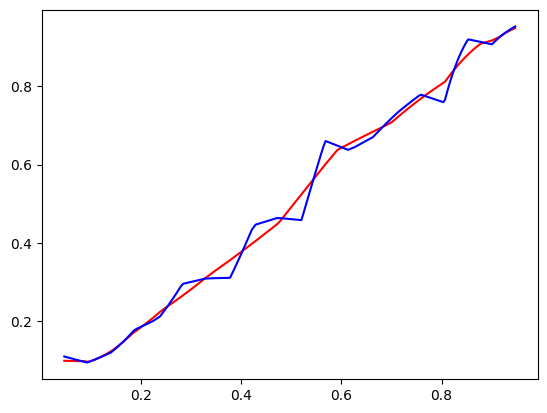

In [40]:
plot(df)